In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm



from DiffusionLibs import DiffusionQLearner


In [2]:
import numpy as np

# 1. Define mixture components
_centers = np.array([
    [ 0.0,  0.8],
    [ 0.8,  0.0],
    [ 0.0, -0.8],
    [-0.8,  0.0],
])    # shape (4,2)

# Reward means and default shared standard deviation
_reward_means = np.array([0.5, 0.0, -1.0, 1.0])
_reward_std   = 0.5

def reward_function(actions: np.ndarray, reward_std: float = _reward_std):
    """
    Given either:
      - actions of shape (2,)  → returns a single float reward
      - actions of shape (M,2) → returns an array of M rewards

    For each action, finds the nearest Gaussian center j and samples
      r ~ N(_reward_means[j], reward_std^2).
    """
    a = np.asarray(actions, dtype=float)
    # ensure we have a batch dimension
    was_single = (a.ndim == 1)
    if was_single:
        a = a[None, :]            # shape now (1,2)

    # compute pairwise distances: (M,1,2) - (1,4,2) → (M,4,2) then norm → (M,4)
    # equivalently: broadcast
    diffs = a[:, None, :] - _centers[None, :, :]   # (M,4,2)
    dists = np.linalg.norm(diffs, axis=2)           # (M,4)
    idxs = np.argmin(dists, axis=1)                 # (M,)

    # sample rewards
    rewards = _reward_means[idxs] + reward_std * np.random.randn(len(idxs))

    return rewards[0] if was_single else rewards


def generate_mixed_gaussian_dataset(
    M: int = 10000,
    action_sigma: float = 0.05,
    reward_std: float   = _reward_std,
    state_dim: int      = 1
):
    """
    Generate D = {(s, a, r, s')} for a 2D bandit where:
      - a ~ 0.25 * sum_{j=1}^4 N(mu_j, action_sigma^2 I)
      - r | a ~ N(mean_j, reward_std^2) via reward_function
      - s = s' = 0 (constant bandit state)

    Returns:
      states:      (M, state_dim) array of zeros
      actions:     (M, 2)           array of samples
      rewards:     (M,)             array of rewards
      next_states: (M, state_dim)   array of zeros
    """
    # 2. Sample which component each action comes from
    comp_idx = np.random.choice(len(_centers), size=M, replace=True)

    # 3. Sample actions
    actions = _centers[comp_idx] + action_sigma * np.random.randn(M, 2)

    # 4. Sample rewards via the batch-capable reward_function
    rewards = reward_function(actions, reward_std)

    # 5. Create constant states s and s'
    states     = np.zeros((M, state_dim))
    next_states = states.copy()

    return states, actions, rewards, next_states



In [3]:
S, A, R, S_next = generate_mixed_gaussian_dataset(M=10000)
print(S.shape, A.shape, R.shape, S_next.shape)

state_dim = S.shape[1]
action_dim = A.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"
diffusionQ_learner = DiffusionQLearner(state_dim, action_dim, device=device)
a = diffusionQ_learner.sample(torch.as_tensor(S[0:1]).float().to(device))
print(a)

(10000, 1) (10000, 2) (10000,) (10000, 1)
tensor([[13.1736, 17.5663]], device='cuda:0')


In [4]:
S, A, R, S_next = generate_mixed_gaussian_dataset(M=10000)
print(S.shape, A.shape, R.shape, S_next.shape)

#print(diffusionQ_learner)

batch_size = 512
epochs = 10
steps_per_epoch = 2000

# Build loader
dataset = TensorDataset(
    torch.as_tensor(S), torch.as_tensor(A),
    torch.as_tensor(R), torch.as_tensor(S_next), 
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

it = iter(loader)
for ep in tqdm(range(1, epochs + 1), desc="Training epochs"):
    for _ in range(steps_per_epoch):
        try:
            batch = next(it)
        except StopIteration:
            it = iter(loader)
            batch = next(it)
        Ld, Lq, loss_critic = diffusionQ_learner.update(batch)
    if ep % (epochs/10) == 0:
        print(f"Epoch {ep:4d}  Ld={Ld:.4f}  Lq={Lq:.7f}  loss_critic={loss_critic:.4f}")


(10000, 1) (10000, 2) (10000,) (10000, 1)


Training epochs:  10%|█         | 1/10 [01:38<14:42, 98.08s/it]

Epoch    1  Ld=0.2806  Lq=-0.0000004  loss_critic=0.4058


Training epochs:  20%|██        | 2/10 [03:25<13:47, 103.45s/it]

Epoch    2  Ld=0.1732  Lq=-0.0000005  loss_critic=0.4256


Training epochs:  30%|███       | 3/10 [05:26<13:00, 111.47s/it]

Epoch    3  Ld=0.1325  Lq=-0.0000005  loss_critic=0.4769


Training epochs:  40%|████      | 4/10 [07:28<11:34, 115.82s/it]

Epoch    4  Ld=0.1395  Lq=-0.0000006  loss_critic=0.4624


Training epochs:  50%|█████     | 5/10 [09:29<09:47, 117.43s/it]

Epoch    5  Ld=0.1858  Lq=-0.0000005  loss_critic=0.4762


Training epochs:  60%|██████    | 6/10 [11:25<07:47, 116.99s/it]

Epoch    6  Ld=0.1456  Lq=-0.0000004  loss_critic=0.4836


Training epochs:  70%|███████   | 7/10 [13:15<05:44, 114.88s/it]

Epoch    7  Ld=0.1490  Lq=-0.0000005  loss_critic=0.5007


Training epochs:  80%|████████  | 8/10 [15:02<03:44, 112.45s/it]

Epoch    8  Ld=0.1422  Lq=-0.0000005  loss_critic=0.5219


Training epochs:  90%|█████████ | 9/10 [16:52<01:51, 111.50s/it]

Epoch    9  Ld=0.1520  Lq=-0.0000005  loss_critic=0.5144


Training epochs: 100%|██████████| 10/10 [18:40<00:00, 112.01s/it]

Epoch   10  Ld=0.1872  Lq=-0.0000005  loss_critic=0.5427


Rewards: 1217.1672520355785
Generated rewards: 1828.402000158123


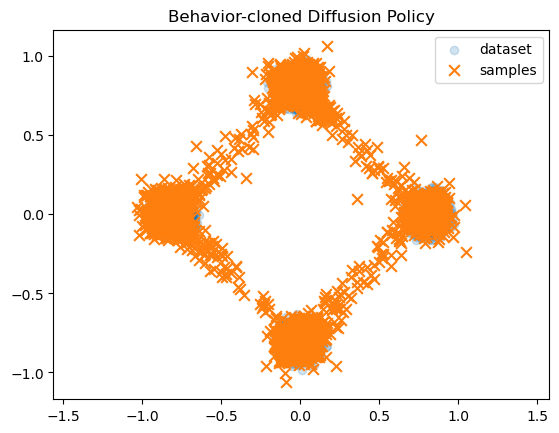

In [33]:
states, actions, _, _ = generate_mixed_gaussian_dataset(M=10000)
action_gen = diffusionQ_learner.sample( torch.as_tensor(states).float().to(device)).cpu().numpy()
rewards = reward_function(actions, _reward_std)
rewards_gen = reward_function(action_gen, _reward_std)
print(f"Rewards: {np.sum(rewards)}")
print(f"Generated rewards: {np.sum(rewards_gen)}")

# Optionally visualize
try:
    import matplotlib.pyplot as plt
    plt.scatter(actions[:,0], actions[:,1], alpha=0.2, label="dataset")
    plt.scatter(action_gen[:,0], action_gen[:,1], marker="x", s=60, label="samples")
    plt.axis("equal"); plt.legend(); plt.title("Behavior-cloned Diffusion Policy")
    plt.show()
except ImportError:
    pass